# Importing the Required Libraries

load all necessary libraries here

In [1]:
# common library
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
from matplotlib import cm
%matplotlib notebook
import pickle
import functools
import operator

# NLP
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

# function
import sys
sys.path.append('function/')
from ursar import nlp

# Importing the Dataset

we load our pickle file from pre-pocessing.ipynb

In [2]:
# load train dataset file here
with open('DATA/clean_text_train', 'rb') as picklefile:
    train = pickle.load(picklefile)

# load test dataset file here
with open('DATA/clean_text_test', 'rb') as picklefile:
    test = pickle.load(picklefile)

In [3]:
# load label train dataset file here
with open('DATA/label_train', 'rb') as picklefile:
    y_train = pickle.load(picklefile)

# load label test dataset file here
with open('DATA/label_test', 'rb') as picklefile:
    y_test = pickle.load(picklefile)

# Parameters

you can tunning this parameter in this section for the model

In [4]:
vocab_size = 1500
embedding_dim = 100
max_length = 120
oov_token = '<UNK>'
padding_type = 'post'
trunc_type = 'post'

# Preparing the Matrix Layer

The "traditional" way to read the text is as follows:
* Create a word dictionary by listing all the words in the dataset
* Each time a string is received, the string is converted into an integer by giving it a number. This numbering can be determined according to the order in the word dictionary that we have. 
* We convert these numbers into a vector (1-dimensional array) that has a length along the many words we have in the dictionary. The array will only be worth 1 or 0 (called one hot encoding). The value 1 is positioned on the index which is the number of the word while the other element is 0. For example for the word "eat", with many of the vocabulary we have is 100 words, then from that word we will get a vector of length 100 that contains 0 all except in position 3 which is worth 1.

## Word to Number Representation

Each review is converted into a vector representation. The number of items in the vector representing a document corresponds to the number of words in the vocabulary. The larger the vocabulary, the longer the vector representation.

Words in a document are scored and the scores are placed in the corresponding location in the representation. We will look at different word scoring methods in the next section (i.e. TF-IDF).

This section is divided into 2 steps:

* Converting reviews to lines of tokens.
* Encoding reviews with a bag-of-words model representation.

## Tokenizer

We will use the Keras API to convert reviews to encoded document vectors.

In [5]:
# create the tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)

# fit the tokenizer on the documents
tokenizer.fit_on_texts(train)

# encode training data set
X_train = tokenizer.texts_to_matrix(train, mode='freq')
print(X_train.shape)

(1780, 1500)


In [6]:
# encode training data set
X_test = tokenizer.texts_to_matrix(test, mode='freq')
print(X_test.shape)

(185, 1500)


In [7]:
# save train dataset
with open('model/tokenizer_ann', 'wb') as picklefile:
    pickle.dump(tokenizer,picklefile)

# Sentiment Analysis Models with simple Simple Neural Network

## Early stopping to prevent overfitting

we can prevent overfitting with Early stopping criteria. 

Early stopping is a method that allows you to specify an arbitrary large number of training epochs and stop training once the model performance stops improving on a hold out validation dataset. we will discover the Keras API for adding early stopping to overfit deep learning neural network models.

In [8]:
# example for early stopping

early_stopping = EarlyStopping(patience = 4)

# and we can add it in model.fit as callback

In [9]:
n_words = X_test.shape[1]

# define network
model = Sequential()

model.add(Dense(128, input_shape=(n_words,), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['acc'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               192128    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 192,257
Trainable params: 192,257
Non-trainable params: 0
_________________________________________________________________
None


In [10]:
history = model.fit(X_train, y_train, 
                    batch_size=128, 
                    epochs=50, 
                    verbose=1,
                    callbacks = [early_stopping,
                        ModelCheckpoint(filepath='model/model_matrix_ANN.h5', 
                                        save_best_only=True)],
                    validation_split=0.1)

Epoch 1/50
13/13 [==============================] - 0s 18ms/step - loss: 0.6795 - acc: 0.6767 - val_loss: 0.6722 - val_acc: 0.6292
Epoch 2/50
13/13 [==============================] - 0s 13ms/step - loss: 0.6480 - acc: 0.6792 - val_loss: 0.6545 - val_acc: 0.6292
Epoch 3/50
13/13 [==============================] - 0s 13ms/step - loss: 0.6204 - acc: 0.6792 - val_loss: 0.6436 - val_acc: 0.6292
Epoch 4/50
13/13 [==============================] - 0s 10ms/step - loss: 0.6013 - acc: 0.6792 - val_loss: 0.6370 - val_acc: 0.6292
Epoch 5/50
13/13 [==============================] - 0s 10ms/step - loss: 0.5829 - acc: 0.6792 - val_loss: 0.6244 - val_acc: 0.6292
Epoch 6/50
13/13 [==============================] - 0s 11ms/step - loss: 0.5637 - acc: 0.6798 - val_loss: 0.6068 - val_acc: 0.6292
Epoch 7/50
13/13 [==============================] - 0s 11ms/step - loss: 0.5416 - acc: 0.6885 - val_loss: 0.5869 - val_acc: 0.6292
Epoch 8/50
13/13 [==============================] - 0s 11ms/step - loss: 0.5156 - a

## Evaluation

In [11]:
cnn_model = load_model('model/model_matrix_ANN.h5')
loss, accuracy = cnn_model.evaluate(X_train, y_train, verbose=False)
print("\nTraining Accuracy: {:.4f}".format(accuracy))
print("Training loss:  {:.4f}".format(loss))
loss, accuracy = cnn_model.evaluate(X_test, y_test, verbose=False)
print("\nTesting Accuracy:  {:.4f}".format(accuracy))
print("Testing loss:  {:.4f}".format(loss))


Training Accuracy: 0.9275
Training loss:  0.2247

Testing Accuracy:  0.7892
Testing loss:  0.4885


# Plot History

<IPython.core.display.Javascript object>


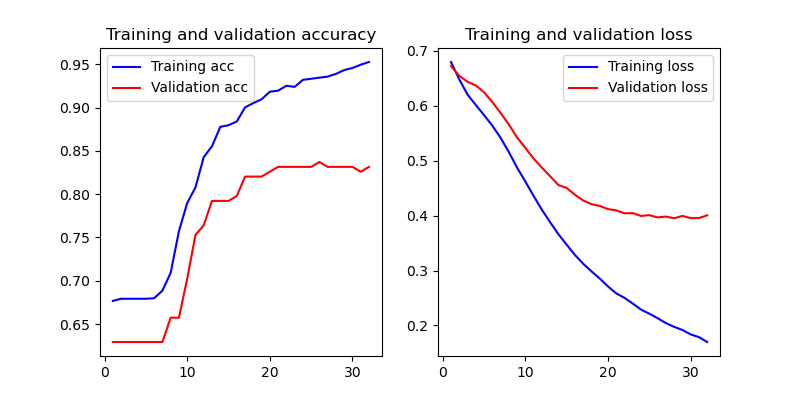

In [12]:
# this function has been save in function/ursar.py so we can call it for every model we create
nlp.plot_history(history)

as you can see, our model begin to overfitting when reach epoch=5 as shown by the distance between training and validation results is growing as epoch become bigger without validation accuracy can catch training accuracy. 

# Comparing Word to Number Representation Methods

The texts_to_matrix() function for the Tokenizer in the Keras API provides 4 different methods for scoring words; they are:
 
 
* “binary” Where words are marked as present (1) or absent (0).
* “count” Where the occurrence count for each word is marked as an integer.
* “tfidf” Where each word is scored based on their frequency, where words that are common across all documents are penalized.
* “freq” Where words are scored based on their frequency of occurrence within the document.


In [13]:
def prepare_data(train, test, mode):
    # create the tokenizer
    tokenizer = Tokenizer()
    # fit the tokenizer on the documents
    tokenizer.fit_on_texts(train)
    # encode training data set
    X_train = tokenizer.texts_to_matrix(train, mode=mode)
    # encode training data set
    X_test = tokenizer.texts_to_matrix(test, mode=mode)
    return X_train, X_test

Because neural networks are stochastic (they can produce different results when the same model is fit on the same data mainly because of the random initial weights and the shuffling of patterns during mini-batch gradient descent), This means that any one scoring of a model is unreliable and we should estimate model skill based on an average of multiple runs.

In [14]:
# evaluate a neural network model
def evaluate_mode(X_train, y_train, X_test, y_test):
    scores = list()
    n_repeats = 30
    n_words = X_test.shape[1]
    for i in range(n_repeats):
        # define network
        model = Sequential()
        model.add(Dense(50, input_shape=(n_words,), activation='relu'))
        model.add(Dense(1, activation='sigmoid'))
        
        # compile network
        model.compile(loss='binary_crossentropy', 
                      optimizer='adam', 
                      metrics=['accuracy'])
        
        # fit network
        model.fit(X_train, y_train, 
                  epochs=50, 
                  verbose=0)
#                   validation_data=(X_test, y_test))
        
        # evaluate
        loss, acc = model.evaluate(X_test, y_test, verbose=0)
        scores.append(acc)
        print('%d accuracy: %s' % ((i+1), acc))
    return scores

In [15]:
modes = ['binary', 'count', 'tfidf', 'freq']
results = pd.DataFrame()
for mode in modes:
    # prepare data for mode
    X_train, X_test = prepare_data(train, test, mode)
    # evaluate model on data for mode
    results[mode] = evaluate_mode(X_train, y_train, X_test, y_test)
# summarize results
print(results.describe())

1 accuracy: 0.7243243455886841
2 accuracy: 0.7297297120094299
3 accuracy: 0.7297297120094299
4 accuracy: 0.7297297120094299
5 accuracy: 0.7297297120094299
6 accuracy: 0.7297297120094299
7 accuracy: 0.7351351380348206
8 accuracy: 0.7297297120094299
9 accuracy: 0.7243243455886841
10 accuracy: 0.7351351380348206
11 accuracy: 0.7351351380348206
12 accuracy: 0.7351351380348206
13 accuracy: 0.7351351380348206
14 accuracy: 0.7297297120094299
15 accuracy: 0.7243243455886841
16 accuracy: 0.7189189195632935
17 accuracy: 0.7297297120094299
18 accuracy: 0.7405405640602112
19 accuracy: 0.745945930480957
20 accuracy: 0.7351351380348206
21 accuracy: 0.7297297120094299
22 accuracy: 0.7297297120094299
23 accuracy: 0.7297297120094299
24 accuracy: 0.7351351380348206
25 accuracy: 0.7351351380348206
26 accuracy: 0.7297297120094299
27 accuracy: 0.7297297120094299
28 accuracy: 0.7243243455886841
29 accuracy: 0.7243243455886841
30 accuracy: 0.7405405640602112
1 accuracy: 0.708108127117157
2 accuracy: 0.708108

<IPython.core.display.Javascript object>


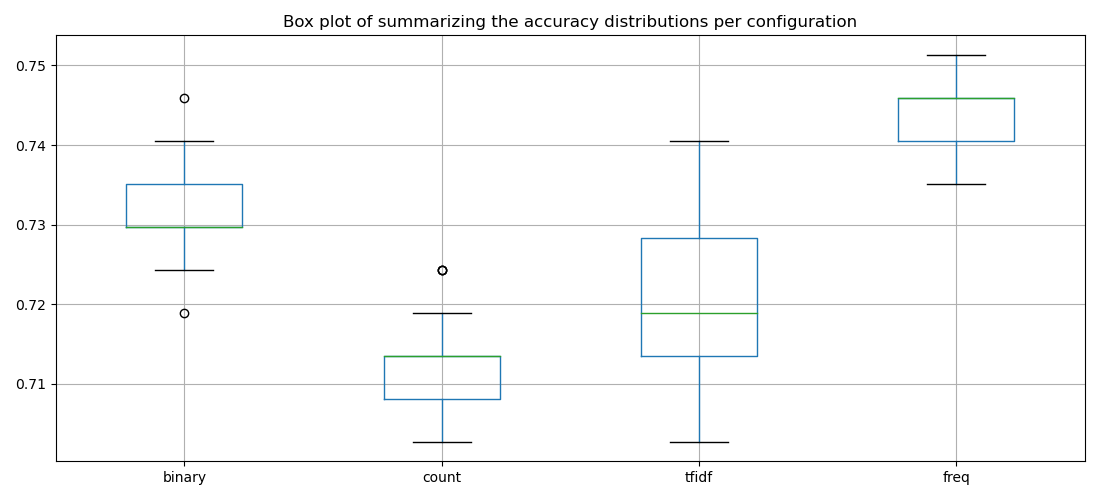

In [16]:
# plot results
fig = plt.subplots( figsize=(11, 5))
results.boxplot()
plt.title('Box plot of summarizing the accuracy distributions per configuration')
plt.tight_layout()
plt.show()

A box and whisker plot of the results is also presented, summarizing the accuracy distributions per configuration.

We can see that the distribution for the ‘freq’ configuration is tight, which is encouraging given that it is also well performing. Additionally, we can see that ‘binary’ achieved the best results with a modest spread and might be the preferred approach for this dataset.

# Making a Prediction for New Reviews

Predicting the sentiment of new reviews involves following the same steps used to prepare the test data. Specifically, loading the text, cleaning the document, filtering tokens by the chosen vocabulary, converting the remaining tokens to a line, encoding it using the Tokenizer, and making a prediction.

In [17]:
# classify a review as negative (0) or positive (1)
def predict_sentiment(review, model):
    # apply preprocess_text function to out training dataset
    reviews = []
    print(review)
    reviews.append(nlp.preprocess_text(review))
    # encode
    encoded = nlp.tokenize_matrix(reviews,"freq")
    # prediction
    yhat = model.predict(encoded, verbose=0)
    if (yhat[0,0]>=0.5):
        res = "positive review"
    else:
        res = "negative review"
    return (res,yhat[0,0])

In [18]:
# load model
model = load_model('model/model_matrix_ANN.h5')

In [19]:
# test positive text
text = 'Saya telah mencoba pasta dan pizza yang mereka hidangkan, rasanya…. Enak!'
print(predict_sentiment(text, model))

Saya telah mencoba pasta dan pizza yang mereka hidangkan, rasanya…. Enak!
('positive review', 0.9892519)
